In [529]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from functools import reduce
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
import re
#from fastai.tabular import add_datepart

In [5]:
train_b = pd.read_excel('Train/train_bureau.xlsx')

In [6]:
train_d = pd.read_excel('Train/train_Data.xlsx')

In [7]:
test_b = pd.read_excel('Test/test_bureau.xlsx')

In [8]:
test_d = pd.read_excel('Test/test_Data.xlsx')

In [13]:
foo = test_b.head(1000)

In [88]:
train_des = pd.read_excel('Train/data_dict.xlsx')

In [110]:
train_d['Top-up Month'].value_counts() #7 classes

No Top-up Service    106677
 > 48 Months           8366
36-48 Months           3656
24-30 Months           3492
30-36 Months           3062
18-24 Months           2368
12-18 Months           1034
Name: Top-up Month, dtype: int64

In [17]:
foo.head()


,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,4,False,PRIMARY,Credit Card,CCC,2019-11-17,Individual,Active,2019-09-26,NaN,...,NaN,0,0.0,NaN,"20191117,",000,"589,","0,","0,",NaN
1,4,False,PRIMARY,Housing Loan,HFC,2019-10-31,Joint,Active,2017-06-21,NaN,...,F03,0,0.0,NaN,"20191031,20190930,20190831,20190731,20190630,2...",0000000000000000000000000000000000000000000000...,"2107227,2122196,2136877,2151448,2165910,218026...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,",120.0
2,4,False,PRIMARY,Property Loan,HFC,2019-10-31,Joint,Active,2017-06-27,NaN,...,F03,0,0.0,NaN,"20191031,20190930,20190831,20190731,20190630,2...",0000000000000000000000000000000000000000000000...,"83458,84051,84632,85209,85781,86349,86913,8747...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,",120.0
3,4,True,PRIMARY,Tractor Loan,NBF,2015-10-31,Individual,Closed,2011-12-29,2015-10-13 00:00:00,...,NaN,0,0.0,NaN,"20151031,20150901,20150831,20150731,20150630,2...",000DDD0270000000000000000000000000000000000000...,"0,,21548,32097,42500,52758,62874,72850,82688,9...","0,,11000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,5,False,PRIMARY,Gold Loan,PRB,2017-08-31,Individual,Closed,2016-05-04,2017-06-15 00:00:00,...,NaN,0,0.0,NaN,"20170630,20170501,20170401,20170331,20170201,2...",000DDDDDD000DDDDDD000DDDDDD000DDDDDD000,"0,,,25846,,,25846,,,25846,,,25846,","0,,,0,,,0,,,0,,,0",",,,,,,,,,,,,,,",NaN


In [15]:
foo.columns

Index(['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
       'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
       'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT',
       'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL',
       'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'ASSET_CLASS',
       'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST',
       'AMT OVERDUE - HIST', 'AMT PAID - HIST', 'TENURE'],
      dtype='object')

In [41]:
foo[['ID','SELF-INDICATOR','MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE','OWNERSHIP-IND', 'ACCOUNT-STATUS','INSTALLMENT-FREQUENCY','ASSET_CLASS']]

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,INSTALLMENT-FREQUENCY,ASSET_CLASS
0,4,False,PRIMARY,Credit Card,CCC,Individual,Active,NaN,NaN
1,4,False,PRIMARY,Housing Loan,HFC,Joint,Active,F03,NaN
2,4,False,PRIMARY,Property Loan,HFC,Joint,Active,F03,NaN
3,4,True,PRIMARY,Tractor Loan,NBF,Individual,Closed,NaN,NaN
4,5,False,PRIMARY,Gold Loan,PRB,Individual,Closed,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,1910,False,PRIMARY,Credit Card,PRB,Individual,Active,NaN,NaN
996,1910,False,PRIMARY,Credit Card,PRB,Individual,Active,NaN,NaN
997,1910,False,PRIMARY,Credit Card,PRB,Individual,Active,NaN,NaN
998,1910,False,PRIMARY,Auto Loan (Personal),NAB,Guarantor,Active,F03,Standard


In [40]:
foo.ID

0         4
1         4
2         4
3         4
4         5
       ... 
995    1910
996    1910
997    1910
998    1910
999    1910
Name: ID, Length: 1000, dtype: int64

In [55]:
pd.crosstab(foo.ID,foo['MATCH-TYPE'],dropna= False)
pd.crosstab(foo.ID,foo['ACCT-TYPE'],dropna= False) #CONTRIBUTOR-TYPE
pd.crosstab(train_b.ID,train_b['INSTALLMENT-FREQUENCY'],dropna= False)
#pd.crosstab(foo.ID,foo['CONTRIBUTOR-TYPE'],dropna= False)
#pd.crosstab(foo.ID,foo['ACCOUNT-STATUS'],dropna= False)
#pd.crosstab(foo.ID,foo['OWNERSHIP-IND'],dropna= False)
pd.crosstab(test_b.ID,test_b['ASSET_CLASS'],dropna= False) #test has one less category 
#pd.crosstab(train_b.ID,train_b['TENURE'],dropna= False) #324 kinds of tenure 

ASSET_CLASS,01,1,Doubtful,Loss,Special Mention Account,Standard,SubStandard
ID,,,,,,,
6,0,0,0,0,0,1,0
25,0,0,0,0,0,1,0
127,0,0,0,0,0,4,0
361,0,0,0,0,0,1,0
393,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...
143396,0,0,0,0,0,5,0
143397,0,0,0,0,0,1,0
143398,0,0,0,0,0,1,0


In [87]:
cols = ['SELF-INDICATOR','MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE','OWNERSHIP-IND', 'ACCOUNT-STATUS',
        'INSTALLMENT-FREQUENCY','ASSET_CLASS']
# for i in cols:
#     train_data_+i = pd.crosstab(train.ID,train[i],dropna= False)
#      train_cols_name.append(train_data_+i)
#     test_data_+i = pd.crosstab(test.ID,test[i],dropna= False)

In [86]:
for i in test_b.columns:
    print("Column name",i)
    print(train_b[i].value_counts(1).reset_index(),test_b[i].value_counts(1).reset_index())

Column name ID
         index        ID
0        71060  0.000749
1       141732  0.000294
2        51786  0.000271
3         1167  0.000246
4        97794  0.000221
...        ...       ...
128650  107223  0.000002
128651  109270  0.000002
128652  116205  0.000002
128653  103121  0.000002
128654    9436  0.000002

[128655 rows x 2 columns]         index        ID
0      114111  0.001453
1      114063  0.000937
2       69953  0.000922
3       26305  0.000922
4      114125  0.000875
...       ...       ...
14740   78473  0.000016
14741  141962  0.000016
14742   62097  0.000016
14743  141994  0.000016
14744   98272  0.000016

[14745 rows x 2 columns]
Column name SELF-INDICATOR
   index  SELF-INDICATOR
0  False        0.707011
1   True        0.292989    index  SELF-INDICATOR
0  False         0.72366
1   True         0.27634
Column name MATCH-TYPE
       index  MATCH-TYPE
0    PRIMARY    0.999649
1  SECONDARY    0.000351        index  MATCH-TYPE
0    PRIMARY    0.999563
1  SECONDARY    0.0

          index  LAST-PAYMENT-DATE
0    2019-09-30           0.014829
1    2019-12-31           0.011070
2    2019-12-05           0.010267
3    2019-12-02           0.006851
4    2019-12-27           0.006839
...         ...                ...
4080 2012-01-15           0.000004
4081 2008-03-29           0.000004
4082 2011-11-04           0.000004
4083 2011-01-16           0.000004
4084 2009-07-03           0.000004

[4085 rows x 2 columns]           index  LAST-PAYMENT-DATE
0    2019-09-30           0.017605
1    2019-10-05           0.014554
2    2019-10-31           0.009120
3    2019-11-02           0.007944
4    2019-03-31           0.007309
...         ...                ...
2790 2016-10-30           0.000032
2791 2011-06-02           0.000032
2792 2013-09-19           0.000032
2793 2006-04-07           0.000032
2794 2013-06-18           0.000032

[2795 rows x 2 columns]
Column name CREDIT-LIMIT/SANC AMT
        index  CREDIT-LIMIT/SANC AMT
0           0               0.305033
1 

                                                    index  DPD - HIST
0                                                       0    0.080850
1                                                     XXX    0.072240
2       0000000000000000000000000000000000000000000000...    0.041260
3       XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...    0.019915
4                                                     000    0.013616
...                                                   ...         ...
134333   000068038007008005008008007007007008008038008038    0.000002
134334  038275XXXXXXXXXXXXDDDDDDXXXXXXXXXXXXXXXDDDXXXX...    0.000002
134335  332XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...    0.000002
134336  0610600290600290610300600600290300270300300290...    0.000002
134337  000000XXXXXXXXXDDDXXXDDDXXXDDDXXXXXXXXXDDDDDDX...    0.000002

[134338 rows x 2 columns]                                                    index  DPD - HIST
0                                                    XXX    0.06

In [105]:
train_b['TENURE'].value_counts(1).reset_index().head(10)

,index,TENURE
0,12.0,0.248478
1,36.0,0.140616
2,0.0,0.093656
3,60.0,0.071828
4,24.0,0.060352
5,48.0,0.037019
6,1.0,0.026399
7,30.0,0.026186
8,6.0,0.021921
9,18.0,0.017558


In [106]:
test_b['TENURE'].value_counts(1).reset_index().head(10)

,index,TENURE
0,12.0,0.163836
1,36.0,0.148839
2,0.0,0.087666
3,24.0,0.080475
4,60.0,0.077542
5,48.0,0.044803
6,6.0,0.024601
7,84.0,0.020107
8,30.0,0.019539
9,1.0,0.018735


In [ ]:
train_b

In [256]:
train_bb = train_b.copy()

In [257]:
test_bb = test_b.copy()

In [91]:
# Data Treatment:
#     -categorical vars

In [ ]:
# id -dont do it
# self indiactor -nochange
# match type- not req
# acct type -required 3 columns chosen for remaning crosstab then combine cols
    -
 #contributor type ARC is not ptesent in test so crosstab and then delete arc   
# ownership indicator no rpoblem
# account status not present in test Sold/Purchased ,Cancelled cross tab then delete                            
# credit limit CREDIT-LIMIT/SANC AMT  DISBURSED-AMT/HIGH CREDIT kbindiscretization
# installment not present in test data F04 F07  F08 crosstab then delete it
# asset class 2 not ptresent in test crosstab and remove it

In [127]:
train_SELF_INDICATOR=pd.crosstab(train.ID,train['SELF-INDICATOR'],dropna= True).reset_index()
test_SELF_INDICATOR=pd.crosstab(test.ID,test['SELF-INDICATOR'],dropna= True).reset_index()

In [129]:
train_MATCH_TYPE=pd.crosstab(train.ID,train['MATCH-TYPE'],dropna= True).reset_index()
test_MATCH_TYPE=pd.crosstab(test.ID,test['MATCH-TYPE'],dropna= True).reset_index()

In [172]:
x = set(train_bb['ACCT-TYPE'].unique())  
y = set(test_bb['ACCT-TYPE'].unique()) 
common = x.intersection(y)
print(list(common)) #now decide cols to keep 

['Property Loan', 'SHG Individual', 'Commercial Vehicle Loan', 'Construction Equipment Loan', 'Loan to Professional', 'Overdraft', 'Microfinance Business Loan', 'Business Non-Funded Credit Facility-Priority Sector-Agriculture', 'Two-Wheeler Loan', 'Business Loan General', 'Personal Loan', 'Loan Against Shares / Securities', 'Microfinance Personal Loan', 'Consumer Loan', 'Tractor Loan', 'Business Loan Unsecured', 'Prime Minister Jaan Dhan Yojana - Overdraft', 'Business Non-Funded Credit Facility General', 'Business Loan - Secured', 'Secured Credit Card', 'Auto Loan (Personal)', 'Gold Loan', 'Pradhan Mantri Awas Yojana - CLSS', 'Individual', 'Business Loan Against Bank Deposits', 'Microfinance Others', 'Mudra Loans   Shishu / Kishor / Tarun', 'Non-Funded Credit Facility', 'Business Loan Priority Sector  Others', 'Business Loan Priority Sector  Agriculture', 'Used Car Loan', 'Credit Card', 'Commercial Equipment Loan', 'Kisan Credit Card', 'Other', 'Loan Against Bank Deposits', 'Microfinan

In [152]:
train_ACCT_TYPE=pd.crosstab(train.ID,train['ACCT-TYPE'],dropna= True).reset_index()
test_ACCT_TYPE=pd.crosstab(test.ID,test['ACCT-TYPE'],dropna= True).reset_index()

cols_to_keep =['Tractor Loan','Gold Loan','Business Loan Priority Sector  Agriculture']

train_ACCT_TYPE["Others"] = pd.DataFrame(train_ACCT_TYPE.drop(columns=cols_to_keep).sum(axis=1))
test_ACCT_TYPE["Others"] = pd.DataFrame(test_ACCT_TYPE.drop(columns=cols_to_keep).sum(axis=1))
filter_cols =cols_to_keep + ['Others'] 
train_ACCT_TYPE = train_ACCT_TYPE.filter(filter_cols)
test_ACCT_TYPE = test_ACCT_TYPE.filter(filter_cols)

In [175]:
train_CONTRIBUTOR_TYPE=pd.crosstab(train.ID,train['CONTRIBUTOR-TYPE'],dropna= True).drop(columns = ['ARC']).reset_index()
test_CONTRIBUTOR_TYPE=pd.crosstab(test.ID,test['CONTRIBUTOR-TYPE'],dropna= True).reset_index()


In [178]:
train_OWNERSHIP_IND=pd.crosstab(train.ID,train['OWNERSHIP-IND'],dropna= True).reset_index()
test_OWNERSHIP_IND=pd.crosstab(test.ID,test['OWNERSHIP-IND'],dropna= True).reset_index()


In [181]:
train_ACCOUNT_STATUS=pd.crosstab(train.ID,train['ACCOUNT-STATUS'],dropna= True).drop(columns=['Sold/Purchased','Cancelled']).reset_index()
test_ACCOUNT_STATUS=pd.crosstab(test.ID,test['ACCOUNT-STATUS'],dropna= True).reset_index()


In [183]:
train_INSTALLMENT_FREQUENCY=pd.crosstab(train.ID,train['INSTALLMENT-FREQUENCY'],dropna= True).drop(columns=['F04','F07','F08']).reset_index()
test_INSTALLMENT_FREQUENCY=pd.crosstab(test.ID,test['INSTALLMENT-FREQUENCY'],dropna= True).reset_index()

In [184]:
train_ASSET_CLASS=pd.crosstab(train.ID,train['ASSET_CLASS'],dropna= True).drop(columns=['2']).reset_index()
test_ASSET_CLASS=pd.crosstab(test.ID,test['ASSET_CLASS'],dropna= True).reset_index()

SELF-INDICATOR,False,True
ID,,
4,3,1
5,7,1
6,10,2
25,1,1
119,1,1
...,...,...
143396,16,23
143397,4,2
143398,4,2


In [376]:
def onehotencoder(train,test,cols=[]):
    
    from sklearn.preprocessing import OneHotEncoder
    #object_cols = catVar1(train) #catVar1 gives desired categorical column and not all object columns
    object_cols=cols
    print(object_cols)
    
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[object_cols]))
    OH_cols_test = pd.DataFrame(OH_encoder.transform(test[object_cols]))

    # One-hot encoding removed index; put it back
    OH_cols_train.index = train.index
    OH_cols_test.index = test.index

    ##hack for restoring columns names just like get dummies
    column_name = OH_encoder.get_feature_names(object_cols)
    OH_cols_train.columns = column_name
    OH_cols_test.columns = column_name
    

    # Remove desired categorical columns (will replace with one-hot encoding)
    num_train = train.drop(object_cols, axis=1)
    num_test = test.drop(object_cols, axis=1)

    # Add one-hot encoded columns to numerical/remaining features
    OH_train = pd.concat([num_train, OH_cols_train], axis=1)
    OH_test = pd.concat([num_test, OH_cols_test], axis=1)
    

    
    print(OH_train.shape,OH_test.shape)
    
    
    return OH_train,OH_test

def targetencoding(train,test,y_train,drop=False,cols=[]):
    import category_encoders as ce
    # Create the encoder itself
    cat_features = cols
    print(f'targest emcoding for features {cat_features}')
    target_enc = ce.TargetEncoder(cols=cat_features)

    

    # Fit the encoder using the categorical features and target
    target_enc.fit(train[cat_features], y_train)
    

    # Transform the features, rename the columns with _target suffix, and join to dataframe
    traintrgtenc = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
    testtrgtenc = test.join(target_enc.transform(test[cat_features]).add_suffix('_target'))

    if drop :
        traintrgtenc = traintrgtenc.drop(cat_features, axis =1)
        testtrgtenc = testtrgtenc.drop(cat_features, axis =1)

    
    print(traintrgtenc.shape,testtrgtenc.shape)
    
    return traintrgtenc,testtrgtenc


def ordinalencoding(train,test,y_train,mapping,drop=False,cols=[]):
    import category_encoders as ce
    # Create the encoder itself
    cat_features = cols
    print(f'ordinal encoding for features {cat_features}')
    target_enc = ce.OrdinalEncoder(cols=cat_features,mapping = mapping)

    

    # Fit the encoder using the categorical features and target
    target_enc.fit(train[cat_features], y_train)
    

    # Transform the features, rename the columns with _target suffix, and join to dataframe
    traintrgtenc = train.join(target_enc.transform(train[cat_features]).add_suffix('_ordinal'))
    testtrgtenc = test.join(target_enc.transform(test[cat_features]).add_suffix('_ordinal'))

    if drop :
        traintrgtenc = traintrgtenc.drop(cat_features, axis =1)
        testtrgtenc = testtrgtenc.drop(cat_features, axis =1)

    
    print(traintrgtenc.shape,testtrgtenc.shape)
    
    return traintrgtenc,testtrgtenc

In [248]:
def clusters(X,K=[2,3,4,5,6,7,8,9]):
    inertias = [] 
    distortions=[]

    for k in K:

        km = KMeans(n_clusters=k, random_state=10)
        cluster_labels = km.fit_predict(X)

        distortions.append(sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]) 

        inertias.append(km.inertia_)

    plt.plot(K, distortions, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Distortion') 
    plt.title('The Elbow Method using Distortion') 
    plt.show()

    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.show()

In [249]:
train_bb.isna().sum()

ID                                0
SELF-INDICATOR                    0
MATCH-TYPE                        0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
DATE-REPORTED                  3683
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-DT                  32150
CLOSE-DT                     251758
LAST-PAYMENT-DATE            319283
CREDIT-LIMIT/SANC AMT        545685
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT              420509
CURRENT-BAL                     233
INSTALLMENT-FREQUENCY        425135
OVERDUE-AMT                  118891
WRITE-OFF-AMT                 19123
ASSET_CLASS                  300376
REPORTED DATE - HIST          19123
DPD - HIST                    19647
CUR BAL - HIST                19123
AMT OVERDUE - HIST            19123
AMT PAID - HIST               20294
TENURE                       368107
dtype: int64

In [259]:
train_bb['DISBURSED-AMT/HIGH CREDIT'] = train_b['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '').astype('float')
test_bb['DISBURSED-AMT/HIGH CREDIT'] = test_b['DISBURSED-AMT/HIGH CREDIT'].str.replace(',', '').astype('float')

In [260]:
train_bb['CURRENT-BAL'] = train_b['CURRENT-BAL'].fillna(0)
test_bb['CURRENT-BAL'] = test_b['CURRENT-BAL'].fillna(0)
train_bb['CURRENT-BAL'] = train_b['CURRENT-BAL'].str.replace(',', '').astype('float')
test_bb['CURRENT-BAL'] = test_b['CURRENT-BAL'].str.replace(',', '').astype('float')

In [ ]:
# for tenure just use drop na

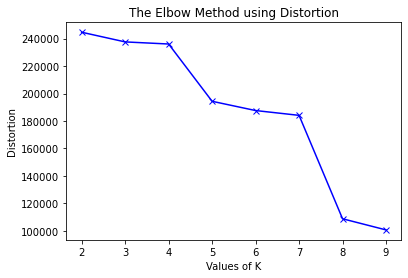

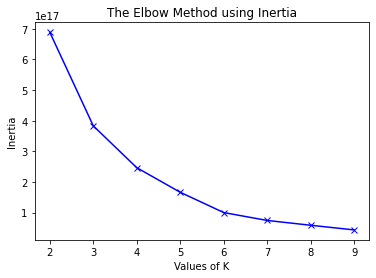

In [250]:
X = train_bb['DISBURSED-AMT/HIGH CREDIT'].values.reshape(-1,1)
clusters(X)

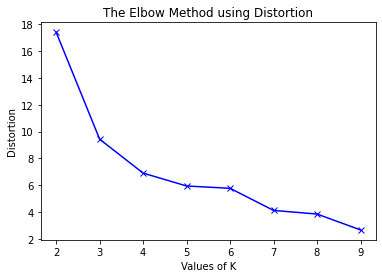

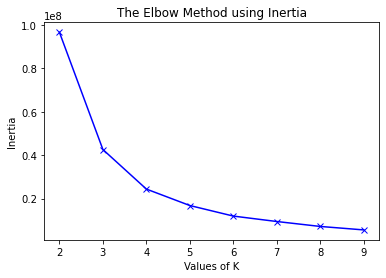

In [251]:
X = train_bb['TENURE'].dropna().values.reshape(-1,1)
clusters(X)

In [335]:

train_CURRENT = train_bb[['CURRENT-BAL','ID']].dropna()
test_CURRENT = test_bb[['CURRENT-BAL','ID']].dropna()

enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
enc.fit(train_bb['CURRENT-BAL'].dropna().values.reshape(-1,1))

train_CURRENT['CURRENT-BAL'] = enc.transform(train_CURRENT['CURRENT-BAL'].values.reshape(-1,1))
test_CURRENT['CURRENT-BAL']= enc.transform(test_CURRENT['CURRENT-BAL'].values.reshape(-1,1))

In [336]:
train_CURRENT=pd.crosstab(train_CURRENT.ID,train_CURRENT['CURRENT-BAL'],dropna= True).reset_index()
test_CURRENT=pd.crosstab(test_CURRENT.ID,test_CURRENT['CURRENT-BAL'],dropna= True).reset_index()
test_CURRENT['3.0']=0

CURRENT-BAL,ID,0.0,1.0,2.0,3.0
0,1,0,9,0,0
1,2,0,13,0,0
2,3,0,31,0,0
3,7,0,4,0,0
4,8,0,7,0,0
...,...,...,...,...,...
128650,143390,0,2,0,0
128651,143391,0,1,0,0
128652,143393,0,4,0,0
128653,143394,0,1,0,0


In [346]:

train_DISBURSED = train_bb[['DISBURSED-AMT/HIGH CREDIT','ID']].dropna()
test_DISBURSED = test_bb[['DISBURSED-AMT/HIGH CREDIT','ID']].dropna()

enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
enc.fit(train_bb['DISBURSED-AMT/HIGH CREDIT'].dropna().values.reshape(-1,1))

train_DISBURSED['DISBURSED-AMT/HIGH CREDIT'] = enc.transform(train_DISBURSED['DISBURSED-AMT/HIGH CREDIT'].values.reshape(-1,1))
test_DISBURSED['DISBURSED-AMT/HIGH CREDIT']= enc.transform(test_DISBURSED['DISBURSED-AMT/HIGH CREDIT'].values.reshape(-1,1))

In [347]:
train_DISBURSED=pd.crosstab(train_DISBURSED.ID,train_DISBURSED['DISBURSED-AMT/HIGH CREDIT'],dropna= True).reset_index()
test_DISBURSED=pd.crosstab(test_DISBURSED.ID,test_DISBURSED['DISBURSED-AMT/HIGH CREDIT'],dropna= True).reset_index()
test_DISBURSED['2.0']=0

In [292]:
#discretisation baes on clusters

train_tenure = train_bb[['TENURE','ID']].dropna()
test_tenure = test_bb[['TENURE','ID']].dropna()

enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
enc.fit(train_bb['TENURE'].dropna().values.reshape(-1,1))

train_tenure['TENURE'] = enc.transform(train_tenure['TENURE'].values.reshape(-1,1))
test_tenure['TENURE']= enc.transform(test_tenure['TENURE'].values.reshape(-1,1))

In [293]:
train_tenure=pd.crosstab(train_tenure.ID,train_tenure['TENURE'],dropna= True).reset_index()
test_tenure=pd.crosstab(test_tenure.ID,test_tenure['TENURE'],dropna= True).reset_index()


In [354]:
dataframes = [train_b.ID,train_SELF_INDICATOR,train_INSTALLMENT_FREQUENCY,train_ACCOUNT_STATUS,train_OWNERSHIP_IND,
              train_CONTRIBUTOR_TYPE,train_ACCT_TYPE,train_MATCH_TYPE,train_ASSET_CLASS,train_CURRENT,train_DISBURSED,
              train_tenure]
final_df_train_beauro = reduce(lambda left, right: pd.merge(left, right, on='ID', how='left'), dataframes)

In [355]:
dataframes = [test_b.ID,test_SELF_INDICATOR,test_INSTALLMENT_FREQUENCY,test_ACCOUNT_STATUS,test_OWNERSHIP_IND,
              test_CONTRIBUTOR_TYPE,test_ACCT_TYPE,test_MATCH_TYPE,test_ASSET_CLASS,test_CURRENT,test_DISBURSED,test_tenure]
final_df_test_beauro = reduce(lambda left, right: pd.merge(left, right, on='ID', how='left'), dataframes)

In [ ]:
###### now train data 

In [545]:
train_dd = train_d.copy()
test_dd = test_d.copy()

In [546]:
train_dd.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,...,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,...,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,...,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


In [547]:
train_dd['Top-up Month'].unique()

array([' > 48 Months', 'No Top-up Service', '12-18 Months',
       '36-48 Months', '18-24 Months', '24-30 Months', '30-36 Months'],
      dtype=object)

In [548]:
test_dd.isna().sum()
train_dd.isna().sum()

ID                     0
Frequency              0
InstlmentMode          0
LoanStatus             0
PaymentMode            0
BranchID               0
Area               11653
Tenure                 0
AssetCost              0
AmountFinance          0
DisbursalAmount        0
EMI                    0
DisbursalDate          0
MaturityDAte           1
AuthDate               0
AssetID                0
ManufacturerID         0
SupplierID             0
LTV                    0
SEX                   59
AGE                   59
MonthlyIncome        234
City               11256
State                  0
ZiPCODE              372
Top-up Month           0
dtype: int64

In [549]:
train_dd['SEX'] = train_dd['SEX'].fillna(train_dd['SEX'].mode()[0])
test_dd['SEX'] = test_dd['SEX'].fillna(test_dd['SEX'].mode()[0])

train_dd['AGE'] = train_dd['AGE'].fillna(train_dd['AGE'].mode()[0])
test_dd['AGE'] = test_dd['AGE'].fillna(test_dd['AGE'].mode()[0])

train_dd['MonthlyIncome'] = train_dd['MonthlyIncome'].fillna(train_dd['MonthlyIncome'].mode()[0])
test_dd['MonthlyIncome'] = test_dd['MonthlyIncome'].fillna(test_dd['MonthlyIncome'].mode()[0])

train_dd['ZiPCODE']  =train_dd['ZiPCODE'].fillna(method = 'ffill').astype('int') 
test_dd['ZiPCODE']  =test_dd['ZiPCODE'].fillna(method = 'ffill').astype('int') 

train_dd =train_dd.fillna(method = 'ffill') 
test_dd =test_dd.fillna(method = 'ffill') 

In [550]:
train_dd['AuthDate'] = pd.to_datetime(train_d['AuthDate'] ,errors='coerce')
test_dd['AuthDate'] = pd.to_datetime(test_d['AuthDate'] ,errors='coerce')

train_dd['DisbursalDate'] = pd.to_datetime(train_d['DisbursalDate'] ,errors='coerce')
test_dd['DisbursalDate'] = pd.to_datetime(test_d['DisbursalDate'] ,errors='coerce')

train_dd['MaturityDAte'] = pd.to_datetime(train_d['MaturityDAte'] ,errors='coerce')
test_dd['MaturityDAte'] = pd.to_datetime(test_d['MaturityDAte'] ,errors='coerce')

In [551]:
train_dd['AuthtoMatureDays'] = train_dd['AuthDate'] - train_dd['MaturityDAte']
test_dd['AuthtoMatureDays'] = test_dd['AuthDate'] - test_dd['MaturityDAte']

train_dd['AuthtoDisDays'] = train_dd['AuthDate'] - train_dd['DisbursalDate']
test_dd['AuthtoDisDays'] = test_dd['AuthDate'] - test_dd['DisbursalDate']

In [552]:
train_dd['AuthYear'] = train_dd['AuthDate'].dt.year 
test_dd['AuthtYear'] = test_dd['AuthDate'].dt.year 
train_dd['AuthMonth'] = train_dd['AuthDate'].dt.month 
test_dd['AuthtMonth'] = test_dd['AuthDate'].dt.month 


train_dd['MaturityYear'] = train_d['MaturityDAte'].dt.year 
test_dd['MaturityYear'] = test_d['MaturityDAte'].dt.year 

train_dd['MaturityMonth'] = train_d['MaturityDAte'].dt.month 
test_dd['MaturityMonth'] = test_d['MaturityDAte'].dt.month 

In [553]:
train_dd = train_dd.drop(columns=['City','Area','AuthDate','DisbursalDate','MaturityDAte'])
test_dd = test_dd.drop(columns=['City','Area','AuthDate','DisbursalDate','MaturityDAte'])

In [554]:
mapping_dict = {'No Top-up Service':0, '12-18 Months':1,'18-24 Months':2, '24-30 Months':3, 
                '30-36 Months':4,'36-48 Months':5,' > 48 Months':6}

In [555]:
train_dd['Top-up Month'] = train_dd['Top-up Month'].replace(mapping_dict) 

In [556]:
train_dd['Top-up Month'].value_counts()

0    106677
6      8366
5      3656
3      3492
4      3062
2      2368
1      1034
Name: Top-up Month, dtype: int64

In [557]:
train_dd['Frequency'].unique()
#test_dd['Frequency'].unique() #ordinal

array(['Monthly', 'Quatrly', 'Half Yearly', 'BI-Monthly'], dtype=object)

In [558]:
train_dd['InstlmentMode'].unique()
test_dd['InstlmentMode'].unique() #one hot encoding

array(['Advance', 'Arrear'], dtype=object)

In [559]:
train_dd['LoanStatus'].unique()
test_dd['LoanStatus'].unique() #one hot encoding

array(['Closed', 'Active'], dtype=object)

In [560]:
train_dd['PaymentMode'].unique()
test_dd['PaymentMode'].unique()  # target encoding

# ['PDC_E', 'PDC', 'Direct Debit', 'Billed', 'ECS', 'Auto Debit',
#        'SI Reject', 'ECS Reject', 'Cheque', 'PDC Reject', 'Escrow']   

# ['PDC_E', 'PDC', 'Billed', 'Direct Debit', 'ECS', 'ECS Reject',
#        'SI Reject', 'Cheque', 'Auto Debit', 'PDC Reject']

array(['PDC_E', 'PDC', 'Billed', 'Direct Debit', 'ECS', 'ECS Reject',
       'SI Reject', 'Cheque', 'Auto Debit', 'PDC Reject'], dtype=object)

In [561]:
train_dd['BranchID'].unique()
# test_dd['BranchID'].unique()  # target or leave it as it is delete area and city 

array([  1, 333, 125, 152,   5, 154,  79,   8, 194, 316,   9,  10, 231,
       289, 149, 229,  16,  17,  19,  20, 200,  21, 281, 110, 205, 341,
        22, 311,  29,  24,  26, 202,  25, 243, 272,  32,  38, 309,  39,
        40,  41, 334,  45,  46,  47, 340,  48,  50, 305,  53,  54,  55,
       304, 196, 292, 310,  57,  59, 296,  62, 124,  67,  68,  70,  73,
       324, 275,  71, 318, 338, 314,  72,  76,  85,  91,  93, 130, 131,
       133, 137, 141, 283, 148, 143, 280, 263, 147, 150, 163,  56, 166,
       199, 173, 189, 298, 327, 193, 294, 204, 206, 407, 207, 246, 273,
       301, 376, 343, 116, 325,   6, 330, 336,   3, 328, 308, 209, 265,
       320, 306,  11,  14,  23, 322, 271,  33, 300, 278, 145, 312, 106,
        69, 332, 293, 164,  88,  89,  95, 120, 313, 136, 138, 139, 337,
       302, 326, 342, 151, 162, 335, 303, 195, 379, 370, 406, 380, 323,
       269, 270, 233, 423, 274, 276, 279, 344, 357, 359, 375, 377, 386,
       387, 388, 389, 390, 393, 395, 397, 400, 401, 404, 405, 41

In [562]:
train_dd['Tenure'].value_counts()
test_dd['Tenure'].value_counts() #can be done as target encoding or leave it as it is

36     3770
48     3597
60     2029
24     1416
42      578
       ... 
75        1
108       1
92        1
86        1
270       1
Name: Tenure, Length: 98, dtype: int64

In [563]:
train_dd['ManufacturerID'].value_counts()
test_dd['ManufacturerID'].value_counts() #can be done as target encoding or leave it as it is

1049.0    3524
1046.0    3087
1186.0    1728
1019.0    1542
1060.0    1533
1062.0    1298
1568.0    1183
1187.0     735
3473.0      74
2965.0      20
2608.0      19
2721.0       2
Name: ManufacturerID, dtype: int64

In [564]:
train_dd['SupplierID'].value_counts()
#test_dd['SupplierID'].value_counts() #can be done as target encoding or leave it as it is

42707     1465
29012     1301
38832     1039
89813     1004
27328      735
          ... 
125748       1
105362       1
41757        1
140389       1
137117       1
Name: SupplierID, Length: 4539, dtype: int64

In [565]:
train_dd['AssetID'].value_counts()
#test_dd['AssetID'].value_counts() #no repetition label enco

14425238    1
26856210    1
432888      1
25671318    1
14094476    1
           ..
23303785    1
7931765     1
16423430    1
1666936     1
28319748    1
Name: AssetID, Length: 128655, dtype: int64

In [566]:
#.value_counts()

In [567]:
train_dd['ZiPCODE'].value_counts() #can be again encoded as target or label that is leave as it is.

125001    806
125055    691
584128    524
125050    409
334001    407
         ... 
517297      1
335022      1
501504      1
412804      1
325601      1
Name: ZiPCODE, Length: 9123, dtype: int64

In [568]:
#sex one hot encoding male female

In [569]:
mapping_dict_f= [
{'col': 'Frequency', 'mapping': {'BI-Monthly':0, 'Monthly': 1, 'Quatrly': 2,  'Half Yearly': 3}}
]

In [570]:
f1,f2 = ordinalencoding(train_dd,test_dd,train_dd['Top-up Month'],drop =True,cols=['Frequency'],mapping= mapping_dict_f)

ordinal encoding for features ['Frequency']
(128655, 27) (14745, 26)


C:\Users\HP\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [571]:
f11,f22 = onehotencoder(f1,f2,cols=['InstlmentMode','LoanStatus','SEX'])

['InstlmentMode', 'LoanStatus', 'SEX']
(128655, 30) (14745, 29)


In [572]:
f111,f222 = targetencoding(f11,f22,f11['Top-up Month'],drop=True,cols=['PaymentMode','State','BranchID','ZiPCODE','ManufacturerID']) #because branch id and area same

targest emcoding for features ['PaymentMode', 'State', 'BranchID', 'ZiPCODE', 'ManufacturerID']


C:\Users\HP\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(128655, 30) (14745, 29)


In [573]:
f111.columns

Index(['ID', 'Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI',
       'AssetID', 'SupplierID', 'LTV', 'AGE', 'MonthlyIncome', 'Top-up Month',
       'AuthtoMatureDays', 'AuthtoDisDays', 'AuthYear', 'AuthMonth',
       'MaturityYear', 'MaturityMonth', 'Frequency_ordinal',
       'InstlmentMode_Advance', 'InstlmentMode_Arrear', 'LoanStatus_Active',
       'LoanStatus_Closed', 'SEX_F', 'SEX_M', 'PaymentMode_target',
       'State_target', 'BranchID_target', 'ZiPCODE_target',
       'ManufacturerID_target'],
      dtype='object')

In [576]:
dataframes = [f111,final_df_train_beauro]
final_df_train = reduce(lambda left, right: pd.merge(left, right, on='ID', how='left'), dataframes)

In [575]:
dataframes = [f222,final_df_test_beauro]
final_df_test = reduce(lambda left, right: pd.merge(left, right, on='ID', how='left'), dataframes)

In [589]:
final_df_train.isnull().sum()

ID                      0
Tenure                  0
AssetCost               0
AmountFinance           0
DisbursalAmount         0
                    ...  
3.0_y                   0
0.0_y              145781
1.0_y              145781
2.0                145781
3.0                145781
Length: 88, dtype: int64